In [60]:
from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

import numpy as np
np.set_printoptions(linewidth=105)

<font color='red'>
<center>
# Machine Learning: Unsupervised learning (Part 2)


<font color='blue'> 

# 5. CASE STUDY: EUROSTAT data analysis

## Applying K-means to cluster countries according to their education resourses

Eurostat is the home of the [European Commission data](http://ec.europa.eu/eurostat). Eurostat’s main role is to process and publish comparable statistical information at European level. Data in Eurostat is provided by each member state. Eurostat's re-use policy is free re-use of its data, both for non-commercial and commercial purposes (with some minor exceptions).

In this case study, we are going to retrieve Eurostat data and test clustering algorithms on it. The amount of data in the database is huge, thus we are going to use a small subset for illustration purposes. In our first study, we are going to focus on **indicators on education finance data** among the member states. The data is already downloaded and provided as is in the file `educ_figdp_1_Data.csv`. You can download it directly following this link: 

-`Database by terms>Population and social conditions>Education and training>Indicators on education finance`. 

## 5.1 Formatting data

Let us start having a look at the data.

In [61]:
%reset -f
#Read and check the dataset downloaded from the EuroStat

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
edu=pd.read_csv('./files/education_GDP/educ_figdp_1_Data.csv',na_values=':')
edu.head()

,TIME,GEO,INDIC_ED,Value
0,2002,European Union (27 countries),Total public expenditure on education as % of ...,5.10
1,2002,European Union (27 countries),Total public expenditure on education as % of ...,1.14
2,2002,European Union (27 countries),Total public expenditure on education as % of ...,2.32
3,2002,European Union (27 countries),Total public expenditure on education as % of ...,1.15
4,2002,European Union (27 countries),Total public expenditure on education as % of ...,0.50


In [62]:
edu.tail()

,TIME,GEO,INDIC_ED,Value
4915,2011,Japan,Total public expenditure on education as % of ...,NaN
4916,2011,Japan,Expenditure on educational institutions from p...,NaN
4917,2011,Japan,Public subsidies to the private sector as % of...,NaN
4918,2011,Japan,Expenditure on educational institutions from p...,1.56
4919,2011,Japan,Total public expenditure on education as % of ...,3.67


Data in CSV and databases are often organized in what is called **stacked** or **record** formats. In our case for each year (`TIME`) and country (`GEO`) of the EU as well as some reference countries such as Japan and United States, we have twelve indicators (`INDIC_ED`) on education finance with their values (`Value`). Let us reshape the table into a feature vector style data set. 

To the process of reshaping stacked data into a table is sometimes called **pivoting**.

In [63]:
#Pivot table in order to get a nice feature vector representation with dual indexing by TIME and GEO 
pivedu=pd.pivot_table(edu, values='Value', index=['TIME', 'GEO'], columns=['INDIC_ED'])

pivedu.head()


INDIC_ED       Expenditure on educational institutions from private sources as % of GDP, for all levels of education combined  \
TIME GEO                                                                                                                        
2002 Austria                                                0.38                                                                
     Belgium                                                0.36                                                                
     Bulgaria                                               0.67                                                                
     Croatia                                                0.13                                                                
     Cyprus                                                 1.41                                                                

INDIC_ED       Expenditure on educational institutions from public sources as % of GDP, for all levels of government combined  \
TIME GEO                                                                                                                        
2002 Austria                                                5.30                                                                
     Belgium                                                5.80                                                                
     Bulgaria                                               3.75                                                                
     Croatia                                                3.71                                                                
     Cyprus                                                 5.87                                                                

INDIC_ED       Expenditure on educational institutions from public sources as % of total public expenditure, for all levels of education combined  \
TIME GEO                                                                                                                                            
2002 Austria                                               10.46                                                                                    
     Belgium                                               11.65                                                                                    
     Bulgaria                                               9.49                                                                                    
     Croatia                                                 NaN                                                                                    
     Cyprus                                                14.67                                                                                    

INDIC_ED       Public subsidies to the private sector as % of GDP, for all levels of education combined  \
TIME GEO                                                                                                  
2002 Austria                                                0.37                                          
     Belgium                                                0.29                                          
     Bulgaria                                               0.18                                          
     Croatia                                                 NaN                                          
     Cyprus                                                 0.73                                          

INDIC_ED       Public subsidies to the private sector as % of total public expenditure, for all levels of education combined  \
TIME GEO                                                                                                                       
2002 Austria                                                0.74                                                               
     Belgium  

In [64]:
print('Let us check the two indices:\n')
print('\nPrimary index (TIME): \n' + str(pivedu.index.levels[0].tolist()))
print('\nSecondary index (GEO): \n' + str(pivedu.index.levels[1].tolist()))

Let us check the two indices:


Primary index (TIME): 
[2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011]

Secondary index (GEO): 
['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Euro area (13 countries)', 'Euro area (15 countries)', 'European Union (25 countries)', 'European Union (27 countries)', 'Finland', 'Former Yugoslav Republic of Macedonia, the', 'France', 'Germany (until 1990 former territory of the FRG)', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Japan', 'Latvia', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Turkey', 'United Kingdom', 'United States']


Observe that we have ten years information on these indicators, and as expected we have all members of the European Union with some aggregates and control/reference countries. For the sake of simplicity, let us focus on values on year 2010.

In [65]:
#Extract 2010 set of values
edu2010=pivedu.loc[2010]
edu2010.head()


INDIC_ED,"Expenditure on educational institutions from private sources as % of GDP, for all levels of education combined","Expenditure on educational institutions from public sources as % of GDP, for all levels of government combined","Expenditure on educational institutions from public sources as % of total public expenditure, for all levels of education combined","Public subsidies to the private sector as % of GDP, for all levels of education combined","Public subsidies to the private sector as % of total public expenditure, for all levels of education combined","Total public expenditure on education as % of GDP, at pre-primary level of education (ISCED 0) and not allocated by level","Total public expenditure on education as % of GDP, at primary level of education (ISCED 1)","Total public expenditure on education as % of GDP, at secondary level of education (ISCED 2-4)","Total public expenditure on education as % of GDP, at tertiary level of education (ISCED 5-6)","Total public expenditure on education as % of GDP, for all levels of education combined","Total public expenditure on education as % of gross national income, for all levels of education combined","Total public expenditure on education as % of total public expenditure, for all levels of education combined"
GEO,,,,,,,,,,,,
Austria,0.52,5.25,9.98,0.64,1.22,0.61,1.01,2.64,1.63,5.89,5.90,11.20
Belgium,0.34,6.25,11.90,0.32,0.61,0.78,1.54,2.79,1.46,6.57,6.44,12.51
Bulgaria,0.63,3.35,8.96,0.74,1.99,0.92,0.80,1.76,0.61,4.10,4.18,10.95
Croatia,0.26,4.24,NaN,0.03,NaN,0.65,1.87,0.97,0.78,4.27,4.42,NaN
Cyprus,1.61,6.73,14.59,1.19,2.57,0.40,2.26,3.14,2.12,7.92,8.18,17.16


Let us clean and store the names of the features and the countries.

In [66]:
#Store column names and clear them for better handling. Do the same with countries
edu2010 = edu2010.rename(index={'Euro area (13 countries)': 'EU13',
                                'Euro area (15 countries)': 'EU15',
                                'European Union (25 countries)': 'EU25',
                                'European Union (27 countries)': 'EU27',
                                'Former Yugoslav Republic of Macedonia, the': 'Macedonia',
                                'Germany (until 1990 former territory of the FRG)': 'Germany'
                        })
features = edu2010.columns.tolist()
countries = edu2010.index.tolist()

edu2010.columns=range(12)
edu2010.head()

,0,1,2,3,4,5,6,7,8,9,10,11
GEO,,,,,,,,,,,,
Austria,0.52,5.25,9.98,0.64,1.22,0.61,1.01,2.64,1.63,5.89,5.90,11.20
Belgium,0.34,6.25,11.90,0.32,0.61,0.78,1.54,2.79,1.46,6.57,6.44,12.51
Bulgaria,0.63,3.35,8.96,0.74,1.99,0.92,0.80,1.76,0.61,4.10,4.18,10.95
Croatia,0.26,4.24,NaN,0.03,NaN,0.65,1.87,0.97,0.78,4.27,4.42,NaN
Cyprus,1.61,6.73,14.59,1.19,2.57,0.40,2.26,3.14,2.12,7.92,8.18,17.16


## 5.2 Missing values

As we can observe, this is not a clean data set, there are missing values. Some countries may not collect or have access to some indicators and there are countries without any indicators. Let us display this effect.

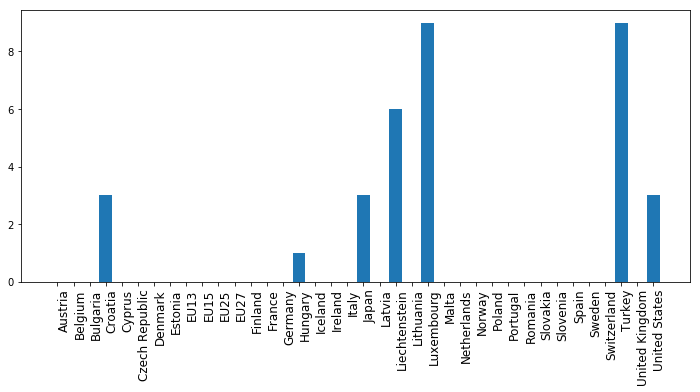

In [67]:
%matplotlib inline

#Check what is going on in the NaN data 
nan_countries=np.sum(np.where(edu2010.isnull(),1,0),axis=1)

plt.bar(np.arange(nan_countries.shape[0]),nan_countries)
plt.xticks(np.arange(nan_countries.shape[0]),countries,rotation=90,
           horizontalalignment='left',fontsize=12)

fig = plt.gcf()
fig.set_size_inches((12,5))

We don't have info on Albania, Macedonia and Greece. And very limited info from Liechtenstein, Luxembourg and Turkey. So let us work without them. Now let us check the features.

In [68]:
#Remove non info countries
wrk_countries = nan_countries<4

educlean=edu2010.loc[wrk_countries] 

#Let us check the features we have
na_features = np.sum(np.where(educlean.isnull(),1,0),axis=0)
print(na_features)

[1 0 3 0 3 0 0 0 0 0 0 3]


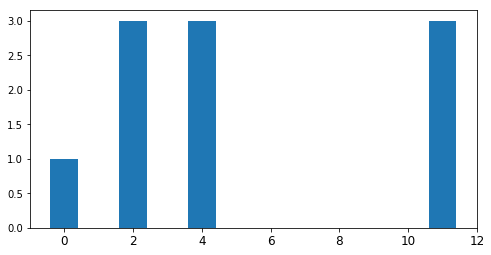

In [69]:
#visualize
plt.bar(np.arange(na_features.shape[0]),na_features)
plt.xticks(fontsize=12)
fig = plt.gcf()
fig.set_size_inches((8,4))

There are four features with missing data. At this point we can proceed in two ways:

+ **Drop** the features with missing values.
+ **Fill in** the features with some non-informative, non-biasing data.

If we have many features and only a few have missing values then it is not much harmful to drop them. However, if missing values are spread across the features, we have to eventually deal with them. In our case, both options seem reasonable, so we will proceed with both at the same time.

In [70]:
#Options A: drop those features
edudrop=educlean.dropna(axis=1) 
         #dropna: Return object with labels on given axis omitted where alternately any or 
          # all of the data are missing
print('Drop data shape: ' + str(edudrop.shape))

Drop data shape: (35, 8)


In [71]:
#Option B fill those features with some value, at risk of extracting wrong information
#Constant filling : edufill0=educlean.fillna(0)
edufill=educlean.fillna(educlean.mean())
print('Filled in data shape: ' + str(edufill.shape))

Filled in data shape: (35, 12)


In the fill-in option, we have decided to fill the data with the mean value of the feature. This will not bias the distribution of the feature, though it has consequences in the interpretation of the results. 

## 5.3 Clustering by k-means

Let us now apply a k-means clustering technique on this data in order to partition the countries according to their investment in education and check their profiles.

In [72]:
#Now we have clean data, create the data set to analyze
X_train = edudrop.values

from sklearn import cluster
clf = cluster.KMeans(init='k-means++', n_clusters=3, random_state=42)
    #‘k-means++’ : selects initial cluster centers for k-mean clustering in a smart way to 
    # speed up convergence.
    
clf.fit(X_train) #Compute k-means clustering.

y_pred_drop = clf.predict(X_train) #Predict the closest cluster each sample in X belongs to.
print(y_pred_drop)

[2 1 0 0 1 0 1 2 2 2 2 2 1 2 2 2 1 1 0 0 2 2 1 2 1 2 2 0 0 2 2 1 2 2 2]


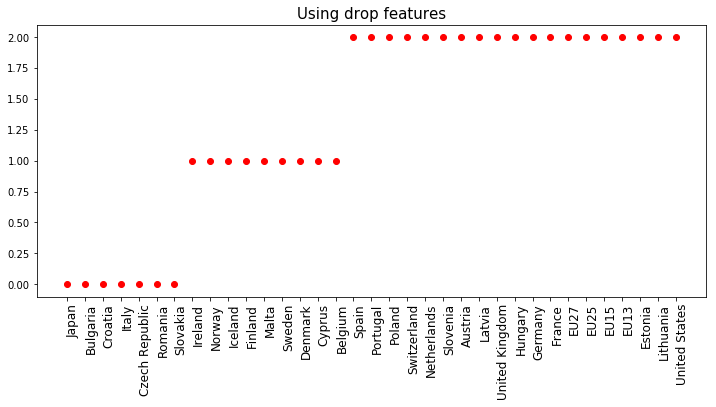

In [73]:
#Let's order the countries
idx=y_pred_drop.argsort()
plt.plot(np.arange(35),y_pred_drop[idx],'ro')

#visualize it
wrk_countries_names = [countries[i] for i,item in enumerate(wrk_countries) if item ]
plt.xticks(np.arange(len(wrk_countries_names)),[wrk_countries_names[i] for i in idx],rotation=90,
           horizontalalignment='left',fontsize=12)
plt.title('Using drop features',size=15)
fig = plt.gcf()
fig.set_size_inches((12,5))


In [74]:
X_train = edufill.values
clf.fit(X_train) #Compute k-means clustering.

y_pred_fill = clf.predict(X_train) #Predict the closest cluster each sample in X belongs to.
print(y_pred_fill)

[2 2 0 0 1 0 1 1 2 2 2 2 2 2 0 0 1 2 0 0 2 2 1 2 1 2 2 0 0 2 2 1 1 2 2]


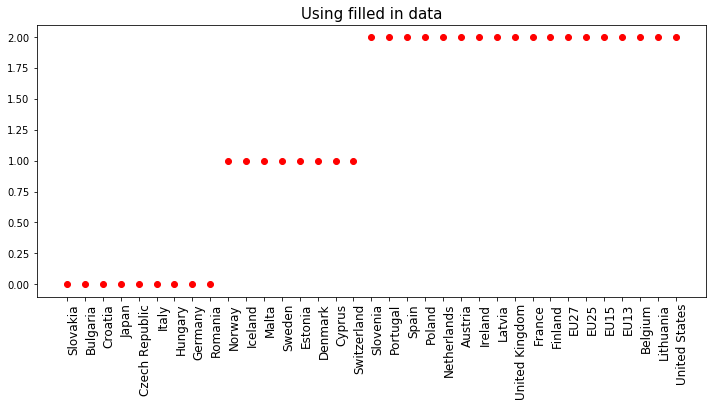

In [75]:
#visualize it
idx=y_pred_fill.argsort()
plt.plot(np.arange(35),y_pred_fill[idx],'ro')

wrk_countries_names = [countries[i] for i,item in enumerate(wrk_countries) if item ]
plt.xticks(np.arange(len(wrk_countries_names)),[wrk_countries_names[i] for i in idx],rotation=90,
           horizontalalignment='left',fontsize=12)
plt.title('Using filled in data', size=15)
fig = plt.gcf()
fig.set_size_inches((12,5))

We have sorted the data for better visualization. At a simple glance we can see that both partitions can be different. We can better check this effect plotting the clusters values of one technique against the other.

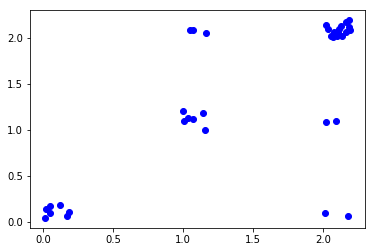

In [76]:
plt.plot(y_pred_drop+0.2*np.random.rand(35),y_pred_fill+0.2*np.random.rand(35),'bo')

Well, looking at both methods, both may yield the same results, but not necessarily always. WHY?

This is mainly due to two aspects: the random initialization of the k-means clustering and the fact that each method works in a different space (dropped data vs filled-in data). 

Let us check the list of countries in both methods. Do not consider the cluster value, since it is irrelevant.

In [77]:
print('Cluster 0: \n' + str([wrk_countries_names[i] for i,item in enumerate(y_pred_drop) if item==0]))
print('Cluster 0: \n' + str([wrk_countries_names[i] for i,item in enumerate(y_pred_fill) if item==0]))
print('\n')
print('Cluster 1: \n' + str([wrk_countries_names[i] for i,item in enumerate(y_pred_drop) if item==1]))
print('Cluster 1: \n' + str([wrk_countries_names[i] for i,item in enumerate(y_pred_fill) if item==1]))
print('\n')
print('Cluster 2: \n' + str([wrk_countries_names[i] for i,item in enumerate(y_pred_drop) if item==2]))
print('Cluster 2: \n' + str([wrk_countries_names[i] for i,item in enumerate(y_pred_fill) if item==2]))
print('\n')


Cluster 0: 
['Bulgaria', 'Croatia', 'Czech Republic', 'Italy', 'Japan', 'Romania', 'Slovakia']
Cluster 0: 
['Bulgaria', 'Croatia', 'Czech Republic', 'Germany', 'Hungary', 'Italy', 'Japan', 'Romania', 'Slovakia']


Cluster 1: 
['Belgium', 'Cyprus', 'Denmark', 'Finland', 'Iceland', 'Ireland', 'Malta', 'Norway', 'Sweden']
Cluster 1: 
['Cyprus', 'Denmark', 'Estonia', 'Iceland', 'Malta', 'Norway', 'Sweden', 'Switzerland']


Cluster 2: 
['Austria', 'Estonia', 'EU13', 'EU15', 'EU25', 'EU27', 'France', 'Germany', 'Hungary', 'Latvia', 'Lithuania', 'Netherlands', 'Poland', 'Portugal', 'Slovenia', 'Spain', 'Switzerland', 'United Kingdom', 'United States']
Cluster 2: 
['Austria', 'Belgium', 'EU13', 'EU15', 'EU25', 'EU27', 'Finland', 'France', 'Ireland', 'Latvia', 'Lithuania', 'Netherlands', 'Poland', 'Portugal', 'Slovenia', 'Spain', 'United Kingdom', 'United States']




## 5.4 Shell we consider a data normalization?

We have been a little careless and proceeded with the clustering of data, without any normalization. Let us go into a little more detail in the data. For the sake of simplicity, let us work just with the drop set.

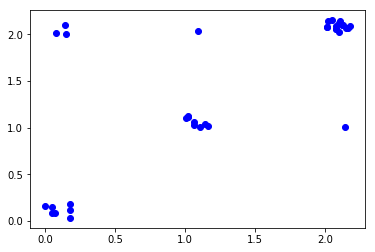

In [78]:
from sklearn.preprocessing import StandardScaler

y_pred_drop_unnorm=y_pred_drop.copy()
X_train = edudrop.values
scaler = StandardScaler() #Standardize features by removing the mean and scaling to unit variance
X_train = scaler.fit_transform(X_train)

clf.fit(X_train)
y_pred_drop = clf.predict(X_train)

#visuaize it
plt.plot(y_pred_drop+0.2*np.random.rand(35),y_pred_drop_unnorm+0.2*np.random.rand(35),'bo')

**QUIZ:** In this case it seems both clustering techniques yield almost the same clusters. Why do you think both yield almost the same results? 

 Let us now check the clusters:

In [79]:
print('Cluster 0: \n' + str([wrk_countries_names[i] for i,item in enumerate(y_pred_drop) if item==0]))

print('Cluster 1: \n' + str([wrk_countries_names[i] for i,item in enumerate(y_pred_drop) if item==1]))

print('Cluster 2: \n' + str([wrk_countries_names[i] for i,item in enumerate(y_pred_drop) if item==2]))

Cluster 0: 
['Bulgaria', 'Croatia', 'Czech Republic', 'Hungary', 'Italy', 'Japan', 'Latvia', 'Romania', 'Slovakia', 'Spain']
Cluster 1: 
['Cyprus', 'Denmark', 'Finland', 'Iceland', 'Ireland', 'Malta', 'Norway', 'Sweden', 'United Kingdom']
Cluster 2: 
['Austria', 'Belgium', 'Estonia', 'EU13', 'EU15', 'EU25', 'EU27', 'France', 'Germany', 'Lithuania', 'Netherlands', 'Poland', 'Portugal', 'Slovenia', 'Switzerland', 'United States']


## 5.5 How to find the average expenditure per cluster?

And check the profile of the clusters by looking at the centroids:

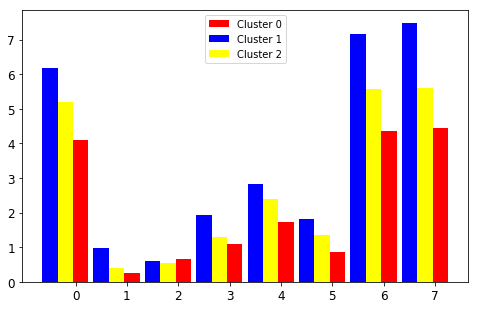

In [80]:
width=0.3
p1 = plt.bar(np.arange(8),scaler.inverse_transform(clf.cluster_centers_[1]),width,color='b')
        # Scale back the data to the original representation
    
p2 = plt.bar(np.arange(8)+width,scaler.inverse_transform(clf.cluster_centers_[2]),width,color='yellow')
p0 = plt.bar(np.arange(8)+2*width,scaler.inverse_transform(clf.cluster_centers_[0]),width,color='r')

#visualize
plt.legend( (p0[0], p1[0], p2[0]), ('Cluster 0', 'Cluster 1', 'Cluster 2') ,loc=9)
plt.xticks(np.arange(8) + 0.5, np.arange(8),size=12)
plt.yticks(size=12)
fig = plt.gcf()
fig.set_size_inches((8,5))

It looks like cluster `1` spends more on education while cluster `0` is the one with less resources on education. 

### And what about Spain?

Let us refine a little bit more cluster `0` and check how close are members from this cluster to cluster `1`. This may give us a hint on a possible ordering. 

In [81]:
from scipy.spatial import distance

p = distance.cdist(X_train[y_pred_drop==0,:],[clf.cluster_centers_[1]],'euclidean') 
                              #the distance of the elements of cluster 0 to the center of cluster 1

([<matplotlib.axis.XTick at 0x1a1b506d30>,
 <a list of 10 Text xticklabel objects>)

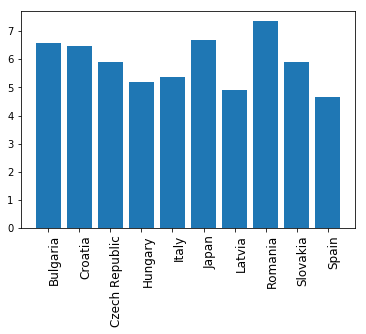

In [82]:

plt.bar(np.arange(p.shape[0]), p.flatten())

wrk_countries_names = [countries[i] for i,item in enumerate(wrk_countries) if item ]
zero_countries_names = [wrk_countries_names[i] for i,item in enumerate(y_pred_drop) if item==0]
plt.xticks(np.arange(len(zero_countries_names)),zero_countries_names,rotation=90,horizontalalignment='left',fontsize=12)

Well, it seems that Spain belongs to cluster `0`, it is the closest to change to a policy in the lines of the other clusters.

Additionally, we can also check the distance to the centroid of cluster `0`.

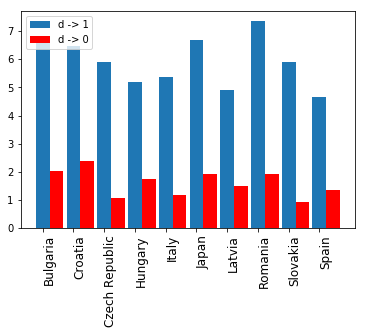

In [83]:
from scipy.spatial import distance

p = distance.cdist(X_train[y_pred_drop==0,:],[clf.cluster_centers_[1]],'euclidean')
pown = distance.cdist(X_train[y_pred_drop==0,:],[clf.cluster_centers_[0]],'euclidean')

width=0.45
p0=plt.bar(np.arange(p.shape[0]),p.flatten(),width)
p1=plt.bar(np.arange(p.shape[0])+width,pown.flatten(),width,color = 'red')

wrk_countries_names = [countries[i] for i,item in enumerate(wrk_countries) if item ]
zero_countries_names = [wrk_countries_names[i] for i,item in enumerate(y_pred_drop) if item==0]
plt.xticks(np.arange(len(zero_countries_names)),zero_countries_names,rotation=90,horizontalalignment='left',fontsize=12)
plt.legend( (p0[0], p1[0]), ('d -> 1', 'd -> 0') ,loc=2)


## 5.6 The number of clusters
The number of cluster has been arbitrarely chosen. We will explore the **elbow/knee technique** for looking for a "good" number $K$. Other references for finding the number of clusters are the GAP statistic or $f(K)$ (Pham et al. 2004) among others.

###  The elbow technique

By the definition of clustering, we want clusters to be compact. The notion of compactness can be measured by checking the distance of the members of the cluster to its centroid. The average distance to its centroid is a naive measure of the overall quality of the cluster. The elbow technique distinguish two phases in the process of checking this value against the number of clusters. In the first phase, the average will decrease dramatically. In the second phase, it will slowly stabilize. The elbow technique consists of selecting the value, where this transition occurs. This can not always be easily found. 

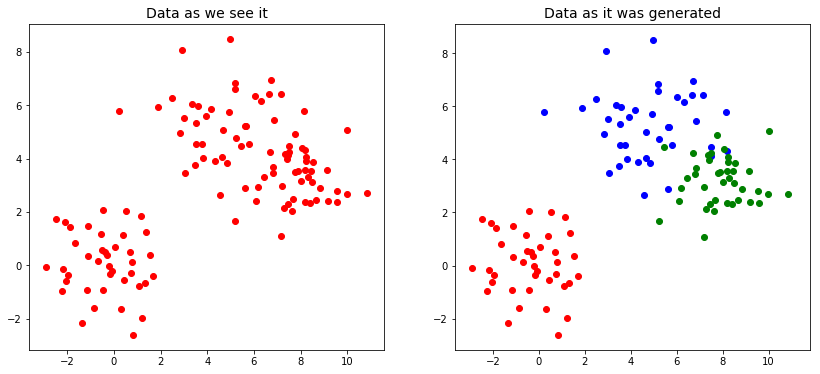

In [84]:
import numpy as np
import matplotlib.pyplot as plt
#Create some data
MAXN=40
X = np.concatenate([1.25*np.random.randn(MAXN,2),5+1.5*np.random.randn(MAXN,2)]) 
X = np.concatenate([X,[8,3]+1*np.random.randn(MAXN,2)])

#Just for visualization purposes
y = np.concatenate([np.ones((MAXN,1)),2*np.ones((MAXN,1))])
y = np.concatenate([y,3*np.ones((MAXN,1))])

plt.subplot(1,2,1)
plt.scatter(X[:,0],X[:,1],color='r')
plt.title('Data as we see it', size=14)

plt.subplot(1,2,2)
plt.scatter(X[(y==1).ravel(),0],X[(y==1).ravel(),1],color='r')
plt.scatter(X[(y==2).ravel(),0],X[(y==2).ravel(),1],color='b')
plt.scatter(X[(y==3).ravel(),0],X[(y==3).ravel(),1],color='g')
plt.title('Data as it was generated',size=14)
fig=plt.gcf()
fig.set_size_inches((14,6))

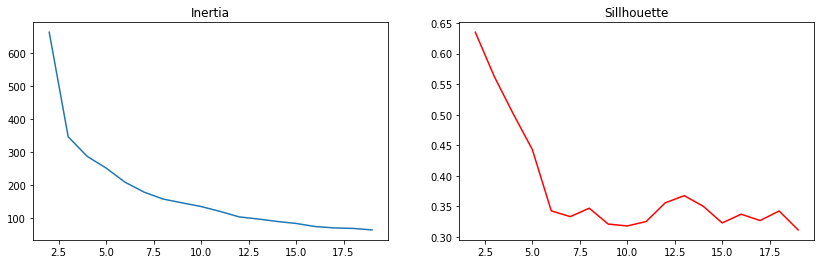

In [85]:
from sklearn import cluster
from sklearn import metrics

pp=[]
iter=20
s=[]
for K in range(2,iter):
    clf = cluster.KMeans(init='random', n_clusters=K, random_state=0)
    clf.fit(X)
    pp.append(clf.inertia_)
    s.append(metrics.silhouette_score(X, clf.labels_,  metric='euclidean'))

plt.subplot(1,2,1)
plt.plot(np.arange(2,iter), pp)
plt.title('Inertia')

plt.subplot(1,2,2)
plt.plot(np.arange(2,iter),s,color='r')
plt.title('Sillhouette')
fig = plt.gcf()
fig.set_size_inches((14,4))

Checking at this graph it seems that $3$ is a good number of clusters. 

Going back to the Eurostat data?

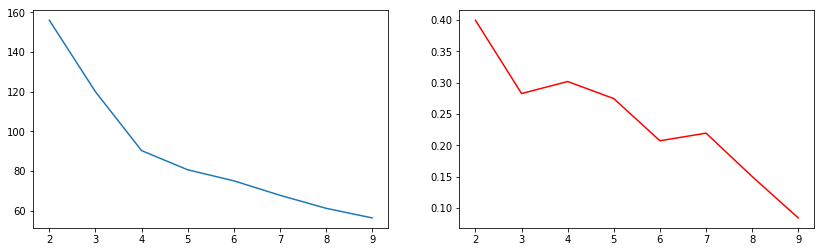

In [86]:
from sklearn import cluster

d=[]
s=[]
for K in range(2,10):
    clf = cluster.KMeans(init='random', n_clusters=K, random_state=0)
    clf.fit(X_train)
    d.append(clf.inertia_)
    s.append(metrics.silhouette_score(X_train, clf.labels_,  metric='euclidean'))

plt.subplot(1,2,1)
plt.plot(np.arange(2,10),d)
plt.subplot(1,2,2)
plt.plot(np.arange(2,10),s,color='r')
fig = plt.gcf()
fig.set_size_inches((14,4))


It looks like $4$ can be a better choice. 

Let us redo the clustering with $K=4$ and see what we can conclude.

In [87]:
X_train = edudrop.values
clf = cluster.KMeans(init='k-means++', n_clusters=4, random_state=0)
clf.fit(X_train)
y_pred = clf.predict(X_train)

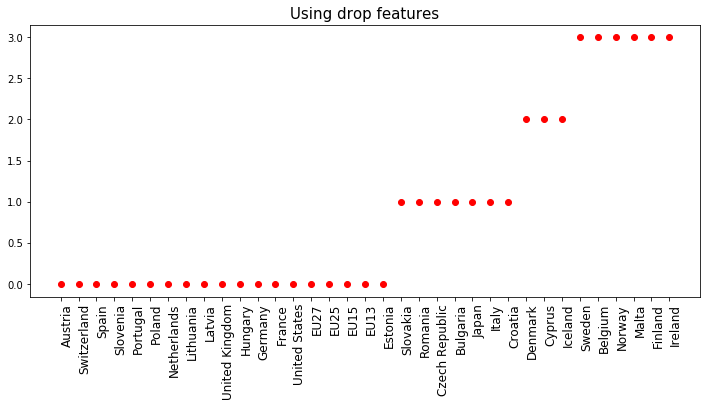

In [88]:
idx=y_pred.argsort()
plt.plot(np.arange(35),y_pred[idx],'ro')
wrk_countries_names = [countries[i] for i,item in enumerate(wrk_countries) if item ]

plt.xticks(np.arange(len(wrk_countries_names)),[wrk_countries_names[i] for i in idx],rotation=90,horizontalalignment='left',fontsize=12)
plt.title('Using drop features',size=15)
fig = plt.gcf()
fig.set_size_inches((12,5))

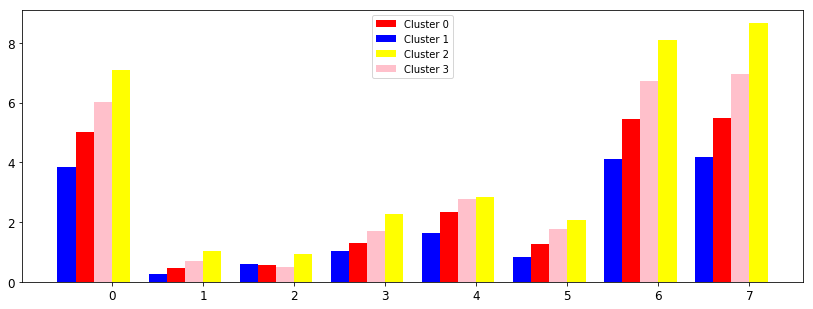

In [89]:
width=0.2
p0 = plt.bar(np.arange(8)+1*width,clf.cluster_centers_[0],width,color='r')
p1 = plt.bar(np.arange(8),clf.cluster_centers_[1],width,color='b')
p2 = plt.bar(np.arange(8)+3*width,clf.cluster_centers_[2],width,color='yellow')
p3 = plt.bar(np.arange(8)+2*width,clf.cluster_centers_[3],width,color='pink')

plt.legend( (p0[0], p1[0], p2[0], p3[0]), ('Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3') ,loc=9)
plt.xticks(np.arange(8) + 0.5, np.arange(8),size=12)
plt.yticks(size=12)
fig = plt.gcf()
fig.set_size_inches((14,5))

Spain is still in cluster `0`. But as we observed in our previous clustering it was very close to changing cluster. This time cluster `0` includes the averages values for the EU members. Just for the sake of completeness, let us write down the name of the countries in the clusters.

In [90]:
print('Cluster 0: \n' + str([wrk_countries_names[i] for i,item in enumerate(y_pred) if item==0]))
print('Cluster 1: \n' + str([wrk_countries_names[i] for i,item in enumerate(y_pred) if item==1]))
print('Cluster 2: \n' + str([wrk_countries_names[i] for i,item in enumerate(y_pred) if item==2]))
print('Cluster 3: \n' + str([wrk_countries_names[i] for i,item in enumerate(y_pred) if item==3]))

#Save data for future use.
import pickle
ofname = open('edu2010.pkl', 'wb')
s = pickle.dump([edu2010, wrk_countries_names,y_pred ],ofname)
ofname.close()

Cluster 0: 
['Austria', 'Estonia', 'EU13', 'EU15', 'EU25', 'EU27', 'France', 'Germany', 'Hungary', 'Latvia', 'Lithuania', 'Netherlands', 'Poland', 'Portugal', 'Slovenia', 'Spain', 'Switzerland', 'United Kingdom', 'United States']
Cluster 1: 
['Bulgaria', 'Croatia', 'Czech Republic', 'Italy', 'Japan', 'Romania', 'Slovakia']
Cluster 2: 
['Cyprus', 'Denmark', 'Iceland']
Cluster 3: 
['Belgium', 'Finland', 'Ireland', 'Malta', 'Norway', 'Sweden']


<div class="alert alert-info">TAKE HOME NOTES:
<p>
<ul>
<li>K-means is a simple, but quite powerful clustering partition technique.
<li>It is very sensitive to variance differences on the features / features at different scales.
<li>It is resistant to irrelevant dimensions as far as they do not introduce biases.
</ul>
</div>

## 5.7 Alternative: Spectral clustering

We can repeat the process using the alternative clustering techniques and compare their results. Let us first apply the **spectral clustering**. The corresponding code will be:

In [91]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import euclidean_distances

X = StandardScaler().fit_transform(edudrop.values)
 
distances = euclidean_distances(edudrop.values)
    
spectral = cluster.SpectralClustering(n_clusters=4, affinity="nearest_neighbors")
spectral.fit(edudrop.values)
 
y_pred = spectral.labels_.astype(np.int)

If we visualize the results:

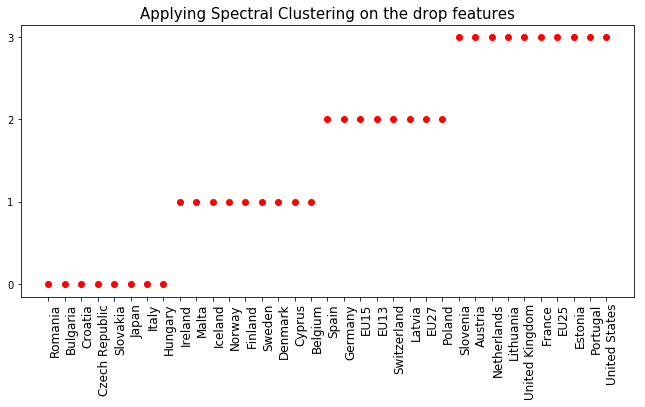

In [92]:
idx=y_pred.argsort()

plt.plot(np.arange(35),y_pred[idx],'ro')
wrk_countries_names = [countries[i] for i,item in enumerate(wrk_countries) if item ]

plt.xticks(np.arange(len(wrk_countries_names)),[wrk_countries_names[i] 
        for i in idx],rotation=90,horizontalalignment='left',fontsize=12)

plt.yticks([0,1,2,3])

plt.title('Applying Spectral Clustering on the drop features',size=15)
fig = plt.gcf()
fig.set_size_inches((11,5))

**Note** that in general, the spectral clustering intends to obtain more balanced clusters. 

## 5.8 Applying the hierarchical clustering to agglomerate countries

Applying the agglomerative clustering, we obtain not only the different clusters, but also we can see how different clusters are obtained. This, in some way it is giving us information on which are the pairs of countries and clusters that are most similar. The corresponding code that applies the agglomerative clustering is:

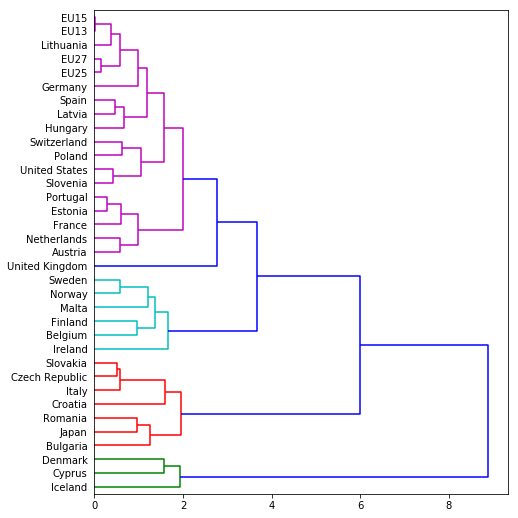

In [93]:
X_train = edudrop.values

dist = pdist(X_train,'euclidean')

linkage_matrix = linkage(dist,method = 'complete');
plt.figure(figsize=(7.3, 7.3))  # we need a tall figure

dendrogram(linkage_matrix, orientation="right", color_threshold = 2,labels = 
           wrk_countries_names, leaf_font_size=10);

plt.tight_layout()  # fixes margins

In scikit-learn, the parameter color_threshold colors all the descendent links below a cluster node k the same color if k is the first node below the color threshold. All links connecting nodes with distances greater than or equal to the threshold are colored blue. Thus, if we use color threshold = 2, the obtained clusters are as follows:

- Cluster 0: ['Cyprus', 'Denmark', 'Iceland']
- Cluster 1: ['Bulgaria', 'Croatia', 'Czech Republic', 'Italy', 'Japan', 'Romania', 'Slovakia']
- Cluster 2: ['Belgium', 'Finland', 'Ireland', 'Malta', 'Norway', 'Sweden']
- Cluster 3: ['Austria', 'Estonia', 'EU13', 'EU15', 'EU25', 'EU27', 'France', 'Germany', 'Hungary', 'Latvia', 'Lithuania', 'Netherlands', 'Poland', 'Portugal', 'Slovenia', 'Spain', 'Switzerland', 'United Kingdom', 'United States']

Note that they correspond in high degree to the clusters obtained by the K-means (except permutation of clusters labels that is irrelevant). The figure shows the construction of the clusters using the complete linkage agglomerative clustering. Different cuts at different levels of the dendrogram allow to obtain different number of clusters. As a summary, let us compare the results of the three approaches of clustering. We cannot expect that the results coincide since different approaches are based on different criteria to construct the clusters. Still, we can observe that in this case K-means and the agglomerative approaches gave the same results (up to a permutation of the number of cluster that is irrelevant), meanwhile the spectral clustering gave more evenly distributed clusters.  Note that these results can change when using different distance between data.

<small><i> This notebook was created by [Petia Radeva](http://www.cvc.uab.es/~petia) and [Oriol Pujol Vila](http://www.maia.ub.es/~oriol). Last edition: 5 of February, 2019.</i></small>